In [30]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from datetime import date
from pandas import to_datetime
from datetime import timedelta

In [28]:
y_train.shape

(48,)

In [12]:
#1676 = TODAY
the_input = "2019-05-03"
today=date.today()
date_difference = today - to_datetime(the_input).date()
begin_date = 1676 - date_difference.days

In [13]:
#downlaod data + prepocessing#
df = pd.read_csv('../data/full_data_2011-01-01_2022-11-26.csv')
df_rain = pd.read_csv('../data/data_precipitation.csv', sep=';')
df_temp = pd.read_csv('../data/temperature_data.csv', sep=';')
df_futur_rain = pd.read_csv('../data/future_rain.csv', sep=';')
df_futur_temp = pd.read_csv('../data/future_temp.csv', sep=';')


df = df.loc[[2]].drop(columns='Unnamed: 0').T
df.columns = ['energie']
df['The_date'] = df['energie']
dict_month = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08','Sep': '09','Oct': '10','Nov': '11','Dec': '12'}
for i in range(len(df)):
    day = "".join(re.findall("\d", df.index[i].split(" ", 1)[0]))
    month = dict_month[df.index[i].split(" ")[1]]
    year = "".join(re.findall("\d", df.index[i].split(" ", 1)[1]))
    the_date = f'{day}-{month}-{year}'
    df['The_date'].iloc[i] = the_date
df['The_date'] = pd.to_datetime(df['The_date'])
df_temp.drop(columns=['Unnamed: 17'], inplace = True)
df = df[2557:-18]
df.reset_index(inplace = True)
df_futur_rain['mean'] = df_futur_rain.mean(axis=1)
df_futur_temp['mean'] = df_futur_temp.mean(axis=1)

df_final = pd.DataFrame()
df_final['temp'] = df_futur_temp['mean']
df_final['rain'] = df_futur_rain['mean']
df_final['energie'] = df["energie"]

In [14]:
#smooth curve#
df_final['energie_ma'] = df_final['energie'].rolling(14).mean()
df_final['rain_ma'] = df_final['rain'].rolling(14).mean()
df_final['temp_ma'] = df_final['temp'].rolling(14).mean()

In [15]:
#data scaling#
df_to_scale = ['energie_ma','rain_ma', 'temp_ma']
scaler = StandardScaler()

for column in df_to_scale:
            df_final[column] = scaler.fit_transform(pd.DataFrame(df_final[column],columns=[column]))

In [16]:
#data spliting(train-test-pred)#
X=[]
x=[]
y = []

for i in range(14,begin_date):
    x = []
    x.append(df_final.loc[i, 'temp_ma'])
    x.append(df_final.loc[i, 'rain_ma'])
    x.append(df_final.loc[i, 'energie_ma'])
    X.append(x)
    
y = df_final['energie_ma'][begin_date:begin_date+48]

X_train = np.array(X).astype(np.float32)
y_train = np.array(y).astype(np.float32)

dataset_test = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=50,
    batch_size=32,
)

In [17]:
X_train.shape

(347, 3)

In [18]:
#model + fit#
model = Sequential()
model.add(layers.LSTM(units=32, input_shape=(50,3)))
model.add(layers.Dense(1, activation="linear"))

model.compile(loss='mse', 
              optimizer='adam')

model.fit(dataset_test,
         epochs=150, verbose=0)

2/2 [==============================] - 0s 12ms/step


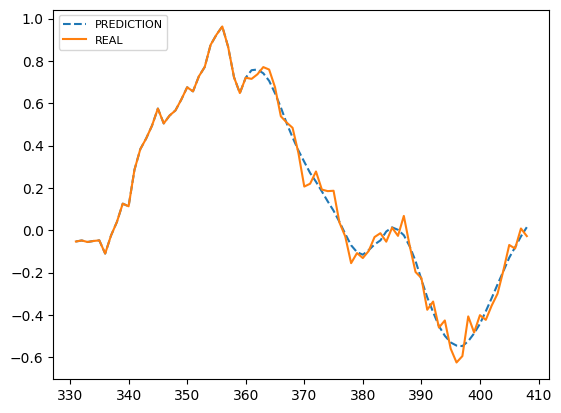

In [19]:
#prediction +plot#
res = model.predict(dataset_test)

df_final['pred'] = df_final['energie_ma']
for i in range(48):
    df_final['pred'][begin_date+i] = res[i]

if begin_date >= 1675:
    plt.plot(df_final['pred'][begin_date-100:begin_date],label='REAL');
    plt.plot(df_final['pred'][begin_date-1:begin_date+48],ls='--',label='PREDICTION');
else:
    plt.plot(df_final['pred'][begin_date-30:begin_date+48],ls='--',label='PREDICTION');
    plt.plot(df_final['energie_ma'][begin_date-30:begin_date+48],label='REAL');
    plt.legend(loc='upper left', fontsize=8);

In [20]:
model

In [21]:
model.save('my_model')


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [22]:
from tensorflow.keras.models import load_model

new_model = load_model('my_model')

In [23]:
y_train.shape

(48,)

In [24]:
y_train
np.ones(48)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
dataset_test = timeseries_dataset_from_array(
    X_train,
    np.ones(48),    
    sequence_length=50,
    batch_size=32,
)

2/2 [==============================] - 1s 19ms/step


RangeIndex(start=0, stop=1789, step=1)

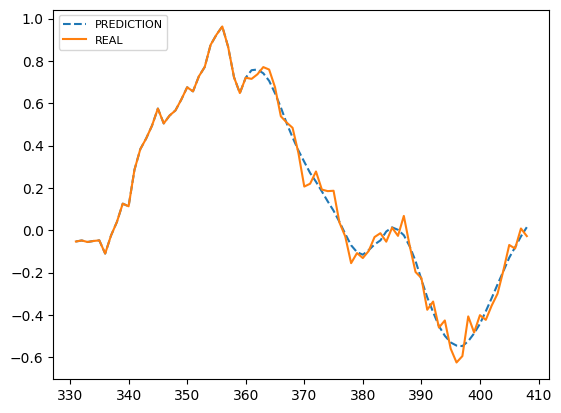

In [26]:
#prediction +plot#
res = new_model.predict(dataset_test)

df_final['pred'] = df_final['energie_ma']
for i in range(48):
    df_final['pred'][begin_date+i] = res[i]

if begin_date >= 1675:
    plt.plot(df_final['pred'][begin_date-100:begin_date],label='REAL');
    plt.plot(df_final['pred'][begin_date-1:begin_date+48],ls='--',label='PREDICTION');
else:
    plt.plot(df_final['pred'][begin_date-30:begin_date+48],ls='--',label='PREDICTION');
    plt.plot(df_final['energie_ma'][begin_date-30:begin_date+48],label='REAL');
    plt.legend(loc='upper left', fontsize=8);

df_final.index 

In [29]:
import requests

url = "http://127.0.0.1:8000/predict/"
files = [("files", X_train),
         ("files", y_train)]

response =requests.post(url,files=files).json()
pred = np.array(response["pred"])
pred

array([[ 0.72422296],
       [ 0.75179607],
       [ 0.74985749],
       [ 0.72388804],
       [ 0.66491717],
       [ 0.59355915],
       [ 0.50527042],
       [ 0.43271527],
       [ 0.37708467],
       [ 0.32266352],
       [ 0.27099571],
       [ 0.22282572],
       [ 0.17112103],
       [ 0.12030804],
       [ 0.07616709],
       [ 0.02869496],
       [-0.01961472],
       [-0.06019017],
       [-0.07407025],
       [-0.08503653],
       [-0.06849177],
       [-0.06500676],
       [-0.06247586],
       [-0.01816968],
       [-0.00553642],
       [-0.01499767],
       [-0.02263052],
       [-0.06703267],
       [-0.13089006],
       [-0.22109634],
       [-0.30808592],
       [-0.38006404],
       [-0.4532043 ],
       [-0.50012106],
       [-0.5338642 ],
       [-0.54979748],
       [-0.55863279],
       [-0.52796125],
       [-0.49372262],
       [-0.432271  ],
       [-0.36880735],
       [-0.31001452],
       [-0.24872112],
       [-0.1862334 ],
       [-0.12697735],
       [-0